In [1]:
import os
import glob
import random
import sys
# import from absolute directory
srcdir = '/Users/pengzhizhang/cellDancer/src'
sys.path.append(srcdir)

import matplotlib.pyplot as plt
import pandas as pd


# Set Parameters

In [37]:
n_neighbors=100
downsample_step=(60,60)

grid=(30,30)
dt = 0.001
t_total = 10000
n_repeats = 10

# Load detail

In [5]:
detail_result_path = '/Users/pengzhizhang/pseudotime/data/Gastrulation/velocity_result'
output_path = os.getcwd()
detail_file = os.path.join(detail_result_path,'combined_detail_2000_genes_with_bin_and_smooth.csv')
load_cellDancer=pd.read_csv(detail_file)

,cellIndex,gene_name,s0,u0,s1,u1,alpha,beta,gamma,cost,clusters,cellID,embedding1,embedding2
0,0,2810025M15Rik,1.515440,0.000000,1.514860,0.000022,0.001560,0.022612,0.005908,0.087183,Blood progenitors 2,cell_363,3.460521,15.574629
1,1,2810025M15Rik,1.574459,0.000000,1.573860,0.000022,0.001522,0.022650,0.005876,0.087183,Blood progenitors 2,cell_382,2.490433,14.971734
2,2,2810025M15Rik,1.744201,0.000000,1.743548,0.000020,0.001426,0.022751,0.005787,0.087183,Blood progenitors 2,cell_385,2.351203,15.267069
3,3,2810025M15Rik,1.332406,0.000000,1.331888,0.000024,0.001682,0.022495,0.006009,0.087183,Blood progenitors 2,cell_393,5.899098,14.388825
4,4,2810025M15Rik,1.261786,0.000000,1.261292,0.000025,0.001732,0.022449,0.006049,0.087183,Blood progenitors 2,cell_398,4.823139,15.374831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24657995,12324,Zrsr2,0.255452,0.030816,0.323642,0.022484,0.005919,0.101278,0.144163,0.126370,Erythroid3,cell_139318,8.032358,7.603037
24657996,12325,Zrsr2,0.204272,0.049630,0.322781,0.036203,0.008434,0.100651,0.142879,0.126370,Erythroid3,cell_139321,10.352904,6.446736
24657997,12326,Zrsr2,0.230350,0.050146,0.349145,0.036532,0.008174,0.100769,0.143180,0.126370,Erythroid3,cell_139326,9.464873,7.261099
24657998,12327,Zrsr2,0.236227,0.052799,0.361591,0.038445,0.008380,0.100769,0.143180,0.126370,Erythroid3,cell_139327,9.990495,7.243880


In [7]:
from compute_cell_velocity import compute_cell_velocity

gene_choice=list(set(load_cellDancer.gene_name))
compute_cell_velocity(load_cellDancer=load_cellDancer,
              gene_list=gene_choice,
              mode="gene",
              n_neighbors=n_neighbors,
              step=downsample_step)

(2000, 12329)
(2000, 12329)


/Users/pengzhizhang/cellDancer/src/compute_cell_velocity.py:138: RuntimeWarning: invalid value encountered in true_divide
  np.sqrt(np.dot(ematrix_ss[:, None], vmatrix_ss[None]))


In [8]:
load_cellDancer

,cellIndex,gene_name,s0,u0,s1,u1,alpha,beta,gamma,cost,clusters,cellID,embedding1,embedding2,index,velocity1,velocity2
0,0,2810025M15Rik,1.515440,0.000000,1.514860,0.000022,0.001560,0.022612,0.005908,0.087183,Blood progenitors 2,cell_363,3.460521,15.574629,0,NaN,NaN
1,1,2810025M15Rik,1.574459,0.000000,1.573860,0.000022,0.001522,0.022650,0.005876,0.087183,Blood progenitors 2,cell_382,2.490433,14.971734,1,NaN,NaN
2,2,2810025M15Rik,1.744201,0.000000,1.743548,0.000020,0.001426,0.022751,0.005787,0.087183,Blood progenitors 2,cell_385,2.351203,15.267069,2,0.022487,-0.008637
3,3,2810025M15Rik,1.332406,0.000000,1.331888,0.000024,0.001682,0.022495,0.006009,0.087183,Blood progenitors 2,cell_393,5.899098,14.388825,3,NaN,NaN
4,4,2810025M15Rik,1.261786,0.000000,1.261292,0.000025,0.001732,0.022449,0.006049,0.087183,Blood progenitors 2,cell_398,4.823139,15.374831,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24657995,12324,Zrsr2,0.255452,0.030816,0.323642,0.022484,0.005919,0.101278,0.144163,0.126370,Erythroid3,cell_139318,8.032358,7.603037,12324,NaN,NaN
24657996,12325,Zrsr2,0.204272,0.049630,0.322781,0.036203,0.008434,0.100651,0.142879,0.126370,Erythroid3,cell_139321,10.352904,6.446736,12325,NaN,NaN
24657997,12326,Zrsr2,0.230350,0.050146,0.349145,0.036532,0.008174,0.100769,0.143180,0.126370,Erythroid3,cell_139326,9.464873,7.261099,12326,NaN,NaN
24657998,12327,Zrsr2,0.236227,0.052799,0.361591,0.038445,0.008380,0.100769,0.143180,0.126370,Erythroid3,cell_139327,9.990495,7.243880,12327,NaN,NaN


There are 5 clusters.
They are:  [0 1 2 3 4]



cluster  0
MAX allowed zero time cells are:  11
53  Cells left.
Sampling new trajectories for zero-time cells in cluster  0   ...
The closest distance is  0.0007169090460754922
Between dot 422  from refPath1 and dot 29 from refPath2.
now the cell time is updated for cluster:  0
shifting ref_path2 by time  393



cluster  0
MAX allowed zero time cells are:  11
Only  1  Cells left. Stopping.



cluster  1
MAX allowed zero time cells are:  10
38  Cells left.
Sampling new trajectories for zero-time cells in cluster  1   ...
The closest distance is  0.019511918531555948
Between dot 68  from refPath1 and dot 0 from refPath2.
now the cell time is updated for cluster:  1
shifting ref_path2 by time  68



cluster  1
MAX allowed zero time cells are:  10
Only  8  Cells left. Stopping.



cluster  2
MAX allowed zero time cells are:  10
38  Cells left.
Sampling new trajectories for zero-time cells in cluster  2   ...
The closest distance is  0.0357484

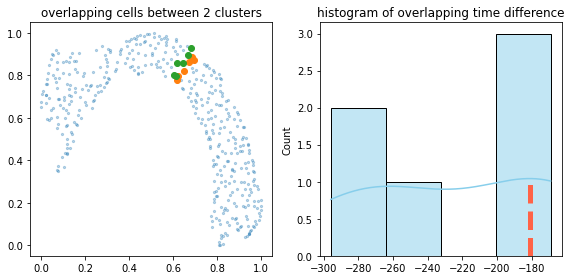

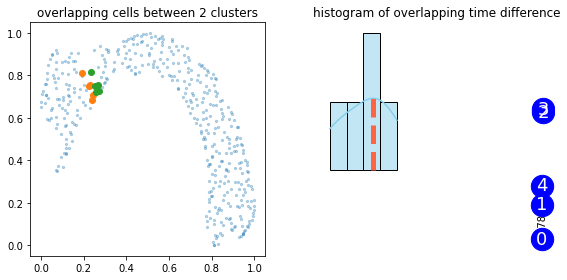

In [ ]:
import importlib
importlib.reload(sys.modules['pseudo_time'])
from pseudo_time import pseudo_time


cell_time = dict()
dt = 0.001
t_total = {dt:int(10/dt)} 
n_repeats = 10
grid = (30,30)
pseudo_time(load_cellDancer, grid, dt, t_total[dt], n_repeats, step)

In [ ]:
load_cellDancer

In [ ]:
clusters = load_cellDancer['clusters'].drop_duplicates().to_list()

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
gene = 'Sulf2'
cdplt.cell.scatter_cell(ax[0],load_cellDancer, colors='alpha', 
             gene_name=gene, velocity=False, custom_xlim=(-5,11), custom_ylim=(4,18))
cdplt.cell.scatter_cell(ax[1],load_cellDancer, colors='beta', 
             gene_name=gene, velocity=False, alpha=0.2, custom_xlim=(-5,11), custom_ylim=(4,18))
cdplt.cell.scatter_cell(ax[2],load_cellDancer, colors=clusters, 
             gene_name=gene, velocity=True, alpha=0.2, custom_xlim=(-5,11), custom_ylim=(4,18))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('alpha-'+gene)
ax[1].set_title('beta-'+gene)
plt.show()